In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.cluster import KMeans
from scipy.special import factorial
from scipy.stats import poisson
from scipy.optimize import minimize

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

In [2]:
###circuit model
Si = np.array([6,0,1])  #sensory input from AWC
Js = np.array([[0,27,-3],[4,0,-3],[0,0,0]]).T  #from the connectome schemtatic
Jg = np.array([[0,3,0],[3,0,10],[0,10,0]]).T*0.002  #from the connectome schemtatic, for gap jucntion

def NL(V,alpha,beta):
    """
    Nonlinearity of neural potential
    """
    R = alpha/(1+np.exp(beta*V))
    #R = np.tanh(V)*0.5+0.5
    return R

def GAP(Jg,V):
    """
    Voltage at the next step given a gap junction network
    """
    Vtemp = np.zeros((len(V),len(V)))
    for ni in range(0,len(V)):
        for nj in range(ni,len(V)):
            Vtemp[ni,nj] = Jg[ni,nj]*(V[nj]-V[ni])
    Vt = Vtemp.sum(0)
    Vt[abs(Vt)>100] = 100
    return Vt

tau = 5  #seams like a 5s time constant from the paper
dt = 0.1
alpha = 1  #saturation value
beta = 0.5  #not sure about the nonlinearity...
sigma = 0.1  #noise strength

In [3]:
Js

array([[ 0,  4,  0],
       [27,  0,  0],
       [-3, -3,  0]])

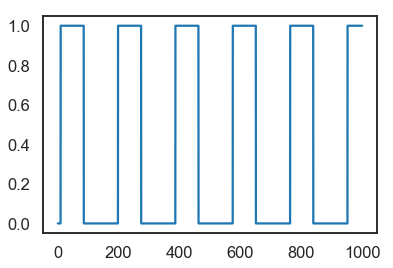

In [11]:
###input
T = 1000
time = np.arange(0,T,dt)
ff = 30
I = np.sin(time/ff)
I[I<0.3] = 0
I[I>0] = 1
plt.plot(time,I)

In [12]:
###neural circuit dynamics
Vs = np.zeros((3,len(time)))
Vs[:,0] = np.random.rand(3)*0.1  #initial condition
ss = 1
for tt in range(0,len(time)-1):
    #if tt>5000:
    #    ss = 0
    Vs[:,tt+1] = Vs[:,tt] + dt*(1/tau)*(-Vs[:,tt] + np.matmul(Js.T,NL(Vs[:,tt],alpha,beta)) \
                                        + Si*I[tt])*ss \
                                        + GAP(Jg,Vs[:,tt])*.1 \
                                        + np.random.randn(3)*sigma*np.sqrt(dt)*np.array([1,1,2])

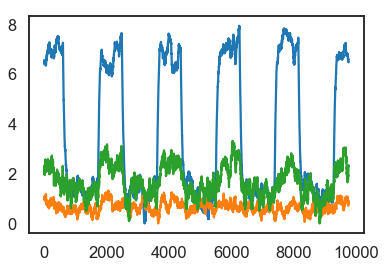

In [13]:
#plt.imshow(I[None,:],aspect='auto')
dataV = Vs[:,int(tau/dt*5):]
dataV = dataV - np.min(dataV,axis=1)[:,None]
plt.plot(dataV[:,:].T);

In [14]:
C = np.zeros((3,3))
for ii in range(3):
    for jj in range(3):
        C[ii,jj] = np.corrcoef(dataV[ii,:],dataV[jj,:])[1][0]

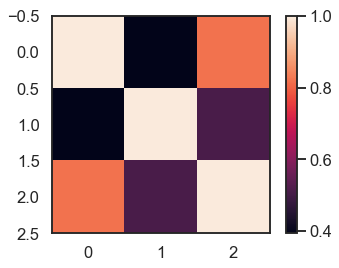

In [15]:
plt.imshow(C)
plt.colorbar();

Text(0, 0.5, 'dF/F_max')

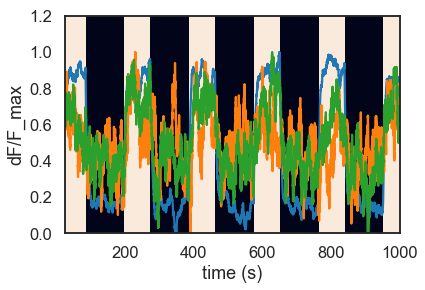

In [16]:
###input driven
remove = int(tau/dt*5)
dataV = Vs[:,remove:]
dataV = dataV - np.min(dataV,axis=1)[:,None]
I_ = I[remove:]
time_ = time[remove:]
plt.imshow(I_[None,:],aspect='auto',extent=[time[remove],np.max(time),np.min(dataV),1.2])#np.max(dataV)])
plt.plot(time_,dataV.T/np.max(dataV,axis=1));
plt.xlabel('time (s)')
plt.ylabel('dF/F_max')

Text(0, 0.5, 'P(dF/F_max)')

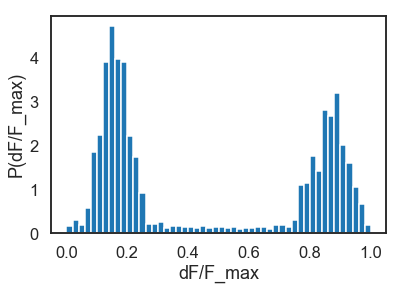

In [17]:
###density
plt.hist(dataV[0,:]/max(dataV[0,:]),bins=50,density=True);
plt.xlabel('dF/F_max')
plt.ylabel('P(dF/F_max)')